In [ ]:
#| default_exp sensors


:::{.callout-tip}

This module can be imported using `from openhsi.sensors import *`

:::

:::{.callout-warning}

Still experimental. Stay tuned.

:::

The OpenHSI camera requires motion to generate 2D spatial datacubes. Yet, motion also introduces other artefacts that need georectification. To correct for spurious motion, we need to collect absolute orientation and geolocation of the camera simultaneously with the camera capture. This is where this module comes in. An IMU, GPS, and Pressure/Humidity/Temperature sensor needs to be read and recorded. 


A Teensy 4.0 operates all the sensors, and devices using a Real Time Operating System (RTOS) like cooperative scheduler to run each component update at the desired frequency. By reducing the I/O, and CPU load on the main development board (the Raspberry Pi 4 with 8 GB RAM), the sensor updates are offloaded to a microcontroller with a real time clock to sync and timestamp each sensor measurement. The whole thing is assembled onto a PCB that stacks with the Raspberry Pi 4 and battery hat. 


| Component      | Rate (Hz) | Info | 
| ----------- | ----------- |   ------ | 
| Teensy 4.0 (uC) |  24 MHz Clock | --- | 
| NEO 9N (GPS)    | 20 Hz       |  I2C @400 kHz (takes ~20 ms per update) |
| BNO055 (IMU)   | 100 Hz        | I2C_1 @400 kHz |
| BME280 (Air)    | 100 Hz       | I2C_1 @400 kHz |
| DS3231 (RTC)   | 100 Hz        | I2C_1 @400 kHz |
| XBee     |  1 Hz    | UART_1 @115,200 Hz (~2 ms per update)
| Raspberry Pi 4 | packets @100 Hz |  UART @921,600 Hz  (~0.8 ms per update)  | 
| Start button | 4 Hz poll  |  button linked to LED notifying status    | 

An XBee is also programmed to check sensor status remotely during operation. This could be useful to diagnose any issues without being physically connected to the microcontroller. A basic streaming dashboard is included. 

In [ ]:
#| hide

# documentation extraction for class methods
from nbdev.showdoc import *

# unit tests using test_eq(...)
from fastcore.test import *

# monkey patching class methods using @patch
from fastcore.foundation import *
from fastcore.foundation import patch

# bring forth **kwargs from an inherited class for documentation
from fastcore.meta import delegates

In [ ]:
#| export

from fastcore.foundation import patch
from fastcore.meta import delegates
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d
from tqdm import tqdm
import warnings
from multiprocessing import Process

import os
from typing import Iterable, Union, Callable, List, TypeVar, Generic, Tuple, Optional
import json
import pickle
from pathlib import Path
import time
import serial
import datetime


Each data packet contains timestamped sensor data. The item fields are then extracted from the raw binary serial stream. 

:::{.callout-note}

The Teensy runs a 32 bit Cortex-M7 so serial packets are padded. In other words, the data struct is padded in contiguous memory so a byte variable followed by float variable will include 3 unused bytes in-between so things are packed as 32 bits at a time.

:::

In [ ]:
#| export
packet_labels = ["rpi_time","rtc_status","imu_status","air_status","gps_status",
                "rtc_time",
                "air_offset","temp","pressure","humidity",
                "imu_offset","imu_cal","quat_w","quat_x","quat_y","quat_z",
                "gps_offset","latitude","longitude","altitude","num_sats","pDOP","footer"]

The data packet is sent as a C struct so we need to decode the binary stream and interpret each byte as the corresponding C type. In each packet, there are status bytes to indicate which sensor has been updated. 

In [ ]:
#| export

def decode_packet(buff:"byte string"=None) -> list:
    """Decode `buff` into a list of decoded variables"""
    if buff is None or len(buff) < 73: return []
    
    contents = [None]*23
    np_buff = np.frombuffer(buff,dtype='uint8').astype(np.uint8)
    
    # sensor status
    contents[ 0] = datetime.datetime.now()   # time of recording this data packet
    #contents[ 0] = np_buff[0].view(np.uint8) # '*' is 42 decimal ASCII
    contents[ 1] = np_buff[1].view(np.uint8) # rtc status
    contents[ 2] = np_buff[2].view(np.uint8) # imu status
    contents[ 3] = np_buff[3].view(np.uint8) # air status
    contents[ 4] = np_buff[4].view(np.uint8) # gps status
    
    # Real Time Clock
    year   = np_buff[ 6: 8].view(np.uint16)[0] # rtc year
    month  = np_buff[ 8].view(np.uint8)        # rtc month
    day    = np_buff[ 9].view(np.uint8)        # rtc day
    hour   = np_buff[10].view(np.uint8)        # rtc hour
    minute = np_buff[11].view(np.uint8)        # rtc minute
    second = np_buff[12].view(np.uint8)        # rtc second
    ms     = np_buff[14:16].view(np.uint16)[0] # rtc ms
    try: contents[ 5] = datetime.datetime(year,month,day,hour,minute,second,ms*1000)
    except ValueError: return [] # packets corrupted
    
    # Humidity, Pressure sensor
    contents[ 6] = np_buff[16:18].view(np.int16)[0]   # humidity timestamp offset [ms]
    contents[ 7] = np_buff[20:24].view(np.float32)[0] # temperature [deg C]
    contents[ 8] = np_buff[24:28].view(np.float32)[0] # pressure [hPa]
    contents[ 9] = np_buff[28:32].view(np.float32)[0] # humidity [relative humidity %]
    
    # Inertial Measurement Unit
    contents[10] = np_buff[32:34].view(np.int16)[0]   # imu timestamp offset [ms]
    contents[11] = np_buff[34].view(np.uint8)         # calibration status
    contents[12] = np_buff[36:40].view(np.float32)[0] # quaternion w
    contents[13] = np_buff[40:44].view(np.float32)[0] # quaternion x
    contents[14] = np_buff[44:48].view(np.float32)[0] # quaternion y
    contents[15] = np_buff[48:52].view(np.float32)[0] # quaternion z
    
    # Global Positioning System
    contents[16] = np_buff[52:54].view(np.int16)[0]  # gps timestamp offset [ms]
    contents[17] = float(np_buff[56:60].view(np.int32)[0])/1e7  # latitude [deg]
    contents[18] = float(np_buff[60:64].view(np.int32)[0])/1e7  # longitude [deg]
    contents[19] = float(np_buff[64:68].view(np.int32)[0])  # altitude [mm above ellipsoid]
    contents[20] = np_buff[68].view(np.uint8)        # number of satellites in view and used in compute
    contents[21] = np_buff[70:72].view(np.uint16)[0] # position DOP [*0.01]
    contents[22] = np_buff[72].view(np.uint8)        # '\n' is 10 decimal ASCII
    
    return contents

Create a standrd interface for the sensor master loop to check if collection shoud stop.

In [ ]:
#| export

class GPIOInterface():
    def __init__(self, start_pin):
        self.start_pin = start_pin
        
        try: 
            import RPi.GPIO as GPIO
        except ModuleNotFoundError:
            try: 
                import Jetson.GPIO as GPIO
            except ModuleNotFoundError:
                print("No module named RPi or Jetson. Did you try `pip install RPi.GPIO` or `pip install Jetson.GPIO`?")
        
        self.GPIO=GPIO
        
        try:
            #GPIO.setwarnings(False)
            self.GPIO.setmode(GPIO.BCM) # BCM pin-numbering scheme from Raspberry Pi
            self.GPIO.setup(self.start_pin, GPIO.IN)
        except NameError:
            warnings.warn(f"GPIO requires Jetson or Raspberry Pi.",stacklevel=2)
         
    def status(self):
        return self.GPIO.input(self.start_pin)
    

class MPInterface():
    def __init__(self, mp_bool):
        self._mp_bool = mp_bool
         
    @property
    def status(self):
        return self._mp_bool.value
    
    @status.setter
    def status(self, value):
        self._mp_bool.value = value
    

In [ ]:
#| export

class SensorStream():
    """Parses ancillary sensor data for saving"""
    def __init__(self, 
                 baudrate:int=921_600,    # baudrate of sensor board
                 port:str="/dev/serial0", # serial port of sensor board
                 toggle_interface=None,   # interface to control loop
                 ssd_dir:str=f"/media/pi/fastssd/", # save dir, absoulte path
                 cam_class=None                     # OpenHSI camera class
                ):
        """Opens a serial port. When the button `start_pin` is pressed, start recording.
        Packets are saved at `ssd_dir`, if None, then mounting/unmountng will not be attempted."""
        
        self.ssd_dir  = ssd_dir
        self.cam_class = cam_class
        self.packets = []
        
        self.toggle_interface = toggle_interface
        
        try:
            self.ser = serial.Serial(port=port,
                                    baudrate=baudrate,
                                    bytesize=serial.EIGHTBITS,
                                    parity=serial.PARITY_NONE,
                                    stopbits=serial.STOPBITS_ONE)
            self.ser.flushInput()
        except Exception as e:
            warnings.warn(f"{e}: could not open port {port}.",stacklevel=2)
        
    def read_packet(self,header:chr = b"*", num_bytes:int = 76, timeout:float = 2.) -> "byte string":
        """Reads at least `num_bytes` of a data packet starting with `header` 
        and times out after `timeout` seconds if packet is invalid."""
        buff = header

        # Check for packet start of frame
        start_time = time.time()
        while True:
            if self.ser.in_waiting > 0:
                b = self.ser.read()
                if b ==  header: break # packet received

            if time.time() > start_time + timeout: 
                print("No data packets.")
                return None

        # read the rest of data packet
        start_time = time.time()
        for i in range(num_bytes):
            if time.time() > start_time + timeout:
                print("Received Incomplete Packet")
                break

            if self.ser.in_waiting > 0:
                buff += self.ser.read()

        return buff
    
    def save(self):
        """Save the data packets. Will save some plots of the data as well."""
        self.directory = f"{self.ssd_dir}/{datetime.datetime.now(datetime.timezone.utc).strftime('%Y_%m_%d')}/"
        Path(self.directory).mkdir(parents=False, exist_ok=True)
        
        df = pd.DataFrame(self.packets,columns=packet_labels)
        self.new_df = self.clean_df(df)
        
        # find the time offset between the board and the system time (including the small delay between loops)
        offset_ms = np.nanmin(df.rpi_time.to_numpy() - df.rtc_time.to_numpy() - np.timedelta64(1, "ms"))
        
        offset_ms /= np.timedelta64(1,"ms") # convert to ms
        
        fname = self.directory+f"{self.new_df.rpi_time[0].strftime('%Y_%m_%d-%H_%M_%S')}_ancillary_{offset_ms:.0f}.pkl"
        with open(fname,"wb") as f:
            pickle.dump(self.new_df,f,protocol=4)
                    
    def master_loop(self,
                    n_lines:int        = 128,  # how many along-track pixels
                    processing_lvl:int = 0,    # desired processing done in real time
                    json_path:str      = None, # path to settings file
                    cal_path:str       = None, # path to calibration file
                    preconfig_meta:str = None, # path to metadata file
                    ssd_dir:str        = None, # path to SSD
                   ):
        """Continuous run saving packets during start button pressed. If you want to capture camera as well, 
        input all the optional parameters."""
        self.is_mounted = False
        self.packets = []

        while True:
            if self.toggle_interface.status == True:

                if not self.is_mounted and self.ssd_dir: 
                    # os.system("mount /dev/sda1");
                    self.is_mounted = True
                    self.ser.write(b'y') # let sensor board know everything is set up
                    if self.cam_class:
                        from openhsi.cameras import switched_camera
                        self.p = Process(target=switched_camera, args=(self.cam_class, n_lines, processing_lvl, json_path,
                                                                           cal_path, preconfig_meta, ssd_dir, self.toggle_interface))
                        self.p.start()

                while self.ser.in_waiting > 0:
                    self.packets.append( decode_packet(self.read_packet()) )
                
                time.sleep(0.001)

            elif self.toggle_interface.status == False: # button off, stop collection and save packets to file

                if self.ssd_dir and (len(self.packets)>0):
                    if self.cam_class:
                        self.ser.write(b'n') # let sensor board to stop sending packets
                        self.save()
                        #os.system("umount /dev/sda1"); self.is_mounted = False # keeps causing problems...
                        self.is_mounted = False # not actually unmounted but lets you keep collecting with button pressses
                        self.packets = []

                time.sleep(0.001)

    def clean_df(self, df:pd.DataFrame) -> pd.DataFrame:
        """Converts time offsets in `df` into datetime and splits sensor readings that update 
        at different rates. Also saves the plots as a picture."""
        rtc_df = df[df.columns][(df["rtc_status"]==1)]
        air_df = df[df.columns][(df["air_status"]==1)]
        imu_df = df[df.columns][(df["imu_status"]==1)]
        gps_df = df[df.columns][(df["gps_status"]==1)]

        air_df.air_offset = air_df.rtc_time + pd.to_timedelta(air_df.air_offset, unit="ms")
        imu_df.imu_offset = imu_df.rtc_time + pd.to_timedelta(imu_df.imu_offset, unit="ms")
        gps_df.gps_offset = gps_df.rtc_time + pd.to_timedelta(gps_df.gps_offset, unit="ms")

        air_df.rename({'air_offset': 'board_time'}, axis=1, inplace=True)
        imu_df.rename({'imu_offset': 'board_time'}, axis=1, inplace=True)
        gps_df.rename({'gps_offset': 'board_time'}, axis=1, inplace=True)

        air_df.drop(["rtc_time","rtc_status","imu_status","air_status","gps_status","footer","imu_offset","gps_offset"],axis=1,inplace=True)
        imu_df.drop(["rtc_time","rtc_status","imu_status","air_status","gps_status","footer","air_offset","gps_offset"],axis=1,inplace=True)
        gps_df.drop(["rtc_time","rtc_status","imu_status","air_status","gps_status","footer","air_offset","imu_offset"],axis=1,inplace=True)

        air_df[["imu_cal","quat_w","quat_x","quat_y","quat_z","latitude","longitude","altitude","num_sats","pDOP"]] = np.nan
        imu_df[["temp","pressure","humidity","latitude","longitude","altitude","num_sats","pDOP"]] = np.nan
        gps_df[["temp","pressure","humidity","imu_cal","quat_w","quat_x","quat_y","quat_z"]] = np.nan

        new_df = pd.concat([air_df,imu_df,gps_df])
        new_df.set_index("board_time",inplace=True)
        new_df.sort_index(inplace=True)

        fig, axes = plt.subplots(nrows=2, ncols=3,figsize=(16,12))
        gps_df.plot(ax=axes[0,0],x="longitude",y="latitude",ylabel="latitude",label="path")
        gps_df.plot(ax=axes[0,1],x="rpi_time",y="num_sats")
        imu_df.plot(ax=axes[0,2],x="rpi_time",y=["quat_w","quat_x","quat_y","quat_z"])
        air_df.plot(ax=axes[1,0],x="rpi_time",y="temp")
        air_df.plot(ax=axes[1,1],x="rpi_time",y="pressure")
        air_df.plot(ax=axes[1,2],x="rpi_time",y="humidity")
        
        fig.savefig(self.directory+f"{new_df.rpi_time[0].strftime('%Y_%m_%d-%H_%M_%S')}_ancillary.png",bbox_inches='tight',transparent=False, pad_inches=0)
        return new_df
    

In [ ]:
show_doc(SensorStream.read_packet)
show_doc(SensorStream.save)
show_doc(SensorStream.master_loop)
show_doc(SensorStream.clean_df)

<h4 id="SensorStream.read_packet" class="doc_header"><code>SensorStream.read_packet</code><a href="__main__.py#L31" class="source_link" style="float:right">[source]</a></h4>

> <code>SensorStream.read_packet</code>(**`header`**:`chr`=*`b'*'`*, **`num_bytes`**:`int`=*`76`*, **`timeout`**:`float`=*`2.0`*)

```
Reads at least `num_bytes` of a data packet starting with `header` 
and times out after `timeout` seconds if packet is invalid.
```

<h4 id="SensorStream.save" class="doc_header"><code>SensorStream.save</code><a href="__main__.py#L59" class="source_link" style="float:right">[source]</a></h4>

> <code>SensorStream.save</code>()

```
Save the data packets. Will save some plots of the data as well.
```

<h4 id="SensorStream.master_loop" class="doc_header"><code>SensorStream.master_loop</code><a href="__main__.py#L78" class="source_link" style="float:right">[source]</a></h4>

> <code>SensorStream.master_loop</code>(**`n_lines`**:`int`=*`128`*, **`processing_lvl`**:`int`=*`0`*, **`json_path`**:`str`=*`None`*, **`cal_path`**:`str`=*`None`*, **`preconfig_meta`**:`str`=*`None`*, **`ssd_dir`**:`str`=*`None`*)

```
Continuous run saving packets during start button pressed. If you want to capture camera as well, 
input all the optional parameters.
```

||Type|Default|Details|
|---|---|---|---|
|**`n_lines`**|`int`|`128`|how many along-track pixels|
|**`processing_lvl`**|`int`|`0`|desired processing done in real time|
|**`json_path`**|`str`|`None`|path to settings file|
|**`cal_path`**|`str`|`None`|path to calibration file|
|**`preconfig_meta`**|`str`|`None`|path to metadata file|
|**`ssd_dir`**|`str`|`None`|path to SSD|


<h4 id="SensorStream.clean_df" class="doc_header"><code>SensorStream.clean_df</code><a href="__main__.py#L121" class="source_link" style="float:right">[source]</a></h4>

> <code>SensorStream.clean_df</code>(**`df`**:`DataFrame`)

```
Converts time offsets in `df` into datetime and splits sensor readings that update 
at different rates. Also saves the plots as a picture.
```

:::{.callout-tip}

The serial port for Raspberry Pi is "/dev/serial0". For the Jetson, it is "/dev/ttyTHS0".

:::

:::{.callout-note}

GPS PPS callbacks are experimental. I haven't found a way to use them effectively.

:::

In [ ]:
#| export

def set_pps_cb(
    gps_pin:int=19, # GPS pulse per second pin
    times_list:List[datetime.datetime]=[], # Any list to append system time when callback is called
    bouncetime_ms:float=10, # Debouncing time for the GPS PPS signal
):
    """Setup a callback that appends the system time to `times_list` each time 
    a GPS pulse per second is detected on `gps_pin`."""
    GPIO.setup(gps_pin,GPIO.IN,pull_up_down=GPIO.PUD_DOWN)
    def pps_cb(channel):
        times_list.append(datetime.datetime.now()-datetime.timedelta(milliseconds=bouncetime_ms))
    GPIO.add_event_detect(gps_pin,GPIO.RISING,callback=pps_cb,bouncetime=bouncetime_ms)

def clear_pps_cb(
    gps_pin:int=19, # GPS pulse per second pin
):
    """Clear the GPS pulse per second callback on `gps_pin`."""
    GPIO.remove_event_detect(gps_pin)

Let's now test this using simulated ancillary sensor data packets.

In [ ]:
#| export

def collect_sim(rtc_offset_ms:float=0) -> list:
    """Generate fake sensor packets for testing."""
    
    contents = [None]*23
    
    # sensor status
    contents[ 0] = datetime.datetime.now()# time of recording this data packet
    contents[ 1] = np.random.randint(9,20)//10 # rtc status
    contents[ 2] = np.random.randint(0,2) # imu status
    contents[ 3] = np.random.randint(0,2) # air status
    contents[ 4] = np.random.randint(0,2) # gps status
    
    contents[ 5] = datetime.datetime.now() + datetime.timedelta(milliseconds=rtc_offset_ms)
    
    # Humidity, Pressure sensor
    contents[ 6] = np.random.randint(0,100)     # humidity timestamp offset [ms]
    contents[ 7] = 25 + 5*np.random.rand()      # temperature [deg C]
    contents[ 8] = 1013.25 + 1*np.random.rand() # pressure [hPa]
    contents[ 9] = 50 + 20*np.random.rand()     # humidity [relative humidity %]
    
    # Inertial Measurement Unit
    contents[10] = np.random.randint(0,100)   # imu timestamp offset [ms]
    contents[11] = np.random.randint(0,256)   # calibration status
    contents[12] = -1+2*np.random.rand() # quaternion w
    contents[13] = -1+2*np.random.rand() # quaternion x
    contents[14] = -1+2*np.random.rand() # quaternion y
    contents[15] = -1+2*np.random.rand() # quaternion z
    
    # Global Positioning System
    contents[16] = np.random.randint(0,100)        # gps timestamp offset [ms]
    contents[17] = np.int32((-33+0.1*np.random.rand())*1e7) /1e7  # latitude [deg *10^-7]
    contents[18] = np.int32((141+0.1*np.random.rand())*1e7) /1e7  # longitude [deg *10^-7]
    contents[19] = np.int32((100+20*np.random.rand())*1e3)  /1e7   # altitude [mm above ellipsoid]
    contents[20] = np.random.randint(0,20)         # number of satellites in view and used in compute
    contents[21] = np.random.randint(0,999)        # position DOP [*0.01]
    contents[22] = 10                              # '\n' is 10 decimal ASCII
    
    return contents

We can simulate data packets for testing purposes. This will generate 77 data packets. You can then save the data - it will be cleaned up so each sensor has its own unique timestamp. 

In [ ]:
#| hardware

toggle_interface = GPIOInterface(start_pin=17)

ss = SensorStream(baudrate = 921_600,
                  port = '/dev/serial0',
                  toggle_interface = toggle_interface,
                  ssd_dir = '.')

ss.packets = []
for i in tqdm(range(77)):
    ss.packets.append(collect_sim(rtc_offset_ms=150))
    time.sleep(0.01)

#ss.save()

/xavier_ssd/mambaforge/envs/openhsi_dev/lib/python3.10/site-packages/Jetson/GPIO/gpio.py:383: RuntimeWarning: This channel is already in use, continuing anyway. Use GPIO.setwarnings(False) to disable warnings
  warnings.warn(
/tmp/ipykernel_20274/2005748132.py:5: UserWarning: [Errno 2] could not open port /dev/serial0: [Errno 2] No such file or directory: '/dev/serial0': could not open port /dev/serial0.
  ss = SensorStream(baudrate = 921_600,
100%|████████████████████████████████████████████████████████████████████████| 77/77 [00:00<00:00, 90.05it/s]


We can also use an infinite loop to continuously save sensor data when a hardware button is latched. When data is saved, a summary plot of the data is also saved alongside. Here I specifically exclude the OpenHSI camera by not providing the argument `cam_name` to `SensorStream.__init__`. 

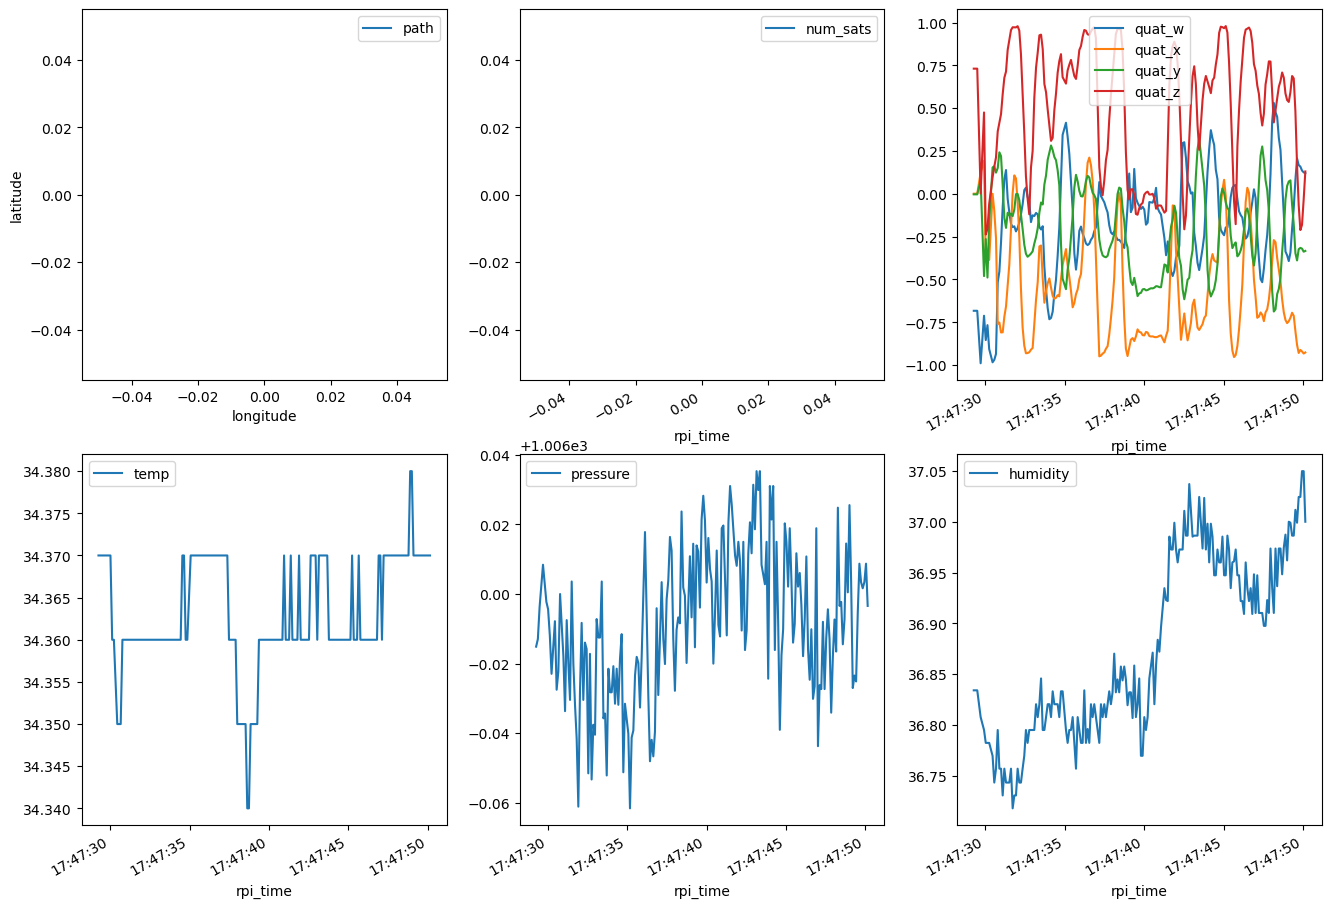

In [ ]:
#| hardware
#| output: false

from multiprocessing import Value
from ctypes import c_bool


import Jetson.GPIO as GPIO
GPIO.setmode(GPIO.BCM) # BCM pin-numbering scheme from Raspberry Pi
GPIO.setup(17, GPIO.OUT)
GPIO.output(17, True)


testMP = MPInterface(Value(c_bool, True))

ss = SensorStream(baudrate = 921_600,
                  toggle_interface=testMP,
                  port = '/dev/ttyTHS0',
                  ssd_dir = '/xavier_ssd/hyperspectral_experiments')
time.sleep(1)
# ss.master_loop()
ss.ser.write(b'y')
packets=0

while ss.ser.in_waiting > 0 and packets < 200:
    packets+=1
    # print(packets)
    ss.packets.append( decode_packet(ss.read_packet()) )
    time.sleep(0.1)
        
ss.ser.write(b'n')
ss.save()

Of course, you can also save ancillary sensor data with the OpenHSI camera datacubes - just provide `cam_name` and also the optional parameters in `SensorStream.master_loop`.

In [ ]:
#| hardware
#| output: false

ss = SensorStream(baudrate = 921_600,
                  port = '/dev/serial0',
                  start_pin = 17,
                  ssd_dir = '/media/pi/fastssd',
                  cam_name="FlirCamera")

ss.master_loop(n_lines=256,
               processing_lvl=2,
               json_path="/media/pi/fastssd/cals/OpenHSI-FLIR01/OpenHSI-FLIR01_settings_Mono8_bin1.json",
               cal_path="/media/pi/fastssd/cals/OpenHSI-FLIR01/OpenHSI-FLIR01_calibration_Mono8_bin1.pkl",
               preconfig_meta=None,
               ssd_dir="/media/pi/fastssd",
               switch_pin=17)

The ancillary sensor timestamps are different from the datacube along-track timestamps so some interpolation is needed. Here is a function that does that for you.

In [ ]:
#| export

def interp2camera_times(df:pd.DataFrame, ts:np.array) -> pd.DataFrame:
    """Interpolate the ancillary sensor data to the timestamps for when 
    each frame was taken with the camera."""
    df_add = pd.DataFrame({"cam_now":ts,"type":"camera"}).set_index("cam_now",inplace=False)
    df.insert(0,"type","sensors")
    df_with_cam = pd.concat([df,df_add]).sort_index()
    
    df_with_cam.interpolate(method="cubicspline",axis="index",limit_direction="both",inplace=True)
    df_with_cam = df_with_cam[df_with_cam.type.str.match("camera")]
    df_with_cam.drop(labels="type", axis=1,inplace=True)

    return df_with_cam
    

## Streaming dashboard

View the XBee status on a dashboard that shows the last 100 points.  This is a simple implementation (it is possible to improve the front end using something like `Dash` and `plotly`).

In [ ]:
#| export
#| output: false

import param
import panel as pn
import hvplot.pandas
import hvplot.streamz
import holoviews as hv
from holoviews.element.tiles import EsriImagery
from holoviews.selection import link_selections
from datashader.utils import lnglat_to_meters
from streamz.dataframe import PeriodicDataFrame
hv.extension('bokeh',logo=False)
from holoviews.streams import Pipe, Buffer

In [ ]:
#| export

class SensorDashboard():
    """A dashboard for viewing ancillary sensor status."""
    def __init__(self, baudrate=115_200, port="/dev/cu.usbserial-DN05TVTD",buff_len:int = 100):
        """Create a dashboard to view ancillary sensor diagnostics."""
        self.ser = serial.Serial(port=port,
                                baudrate=baudrate,
                                bytesize=serial.EIGHTBITS,
                                parity=serial.PARITY_NONE,
                                stopbits=serial.STOPBITS_ONE,)
        
        # Instantiate for storing data
        self.data = []
        self.data_df = pd.DataFrame(None, columns=["lat","lon","sats","temp","pressure","humidity","sys_cal","gyro_cal","accel_cal","mag_cal"])
        
        self.loc_stream = Buffer( pd.DataFrame({"lon":[],"lat":[]}), length=buff_len, index=False)
        #temp = pd.DataFrame({"lon":[151.1,151.2],"lat":[-33.8,-34]})
        #self.loc_stream.send( pd.concat(lnglat_to_meters(temp["lon"],temp["lat"]),axis=1))
        self.loc_dmap = hv.DynamicMap(hv.Scatter,streams=[self.loc_stream]).opts(xlabel="latitude",ylabel="longitude")
        self.map_tiles  = EsriImagery().opts(alpha=0.5,bgcolor='white')
        
        self.sat_stream = Buffer( pd.DataFrame({"sats":[]}), length=buff_len)
        self.sat_dmap   = hv.DynamicMap(hv.Curve,streams=[self.sat_stream]).opts(xlabel="index",ylabel="number of satellites in view")
        
        self.temp_stream = Buffer( pd.DataFrame({"temp":[]}), length=buff_len)
        self.temp_dmap = hv.DynamicMap(hv.Curve,streams=[self.temp_stream]).opts(xlabel="index",ylabel="temperature (deg C)",toolbar=None)
        
        self.pressure_stream = Buffer( pd.DataFrame({"pressure":[]}), length=buff_len)
        self.pressure_dmap   = hv.DynamicMap(hv.Curve,streams=[self.pressure_stream]).opts(xlabel="index",ylabel="pressure (hPa)",toolbar=None)
        
        self.humidity_stream = Buffer( pd.DataFrame({"humidity":[]}), length=buff_len)
        self.humidity_dmap   = hv.DynamicMap(hv.Curve,streams=[self.humidity_stream]).opts(xlabel="index",ylabel="relative humidity %",toolbar=None)
        
        self.sys_stream   = Buffer( pd.DataFrame({"sys_cal":[]}),length=buff_len)
        self.sys_dmap     = hv.DynamicMap(hv.Curve,streams=[self.sys_stream],label="system")
        self.gyro_stream  = Buffer( pd.DataFrame({"gyro_cal":[]}),length=buff_len)
        self.gyro_dmap    = hv.DynamicMap(hv.Curve,streams=[self.gyro_stream],label="gyro")
        self.accel_stream = Buffer( pd.DataFrame({"accel_cal":[]}),length=buff_len)
        self.accel_dmap   = hv.DynamicMap(hv.Curve,streams=[self.accel_stream],label="accel")
        self.mag_stream   = Buffer( pd.DataFrame({"mag_cal":[]}),length=buff_len)
        self.mag_dmap     = hv.DynamicMap(hv.Curve,streams=[self.mag_stream],label="mag")
        
        self.clear_btn = pn.widgets.Button(name='Clear', button_type='primary')
        self.msg = pn.widgets.StaticText(name="")
        self.clear_btn.on_click(self.clear_all)
        self.rpi_ready_btn = pn.widgets.Button(name="Camera Off",button_type="danger")
        self.rpi_ready = False
        self.counter = 0
        
    def run(self):
        """Infinite loop to check sensor status every second."""
        try:
            while True:
                time.sleep(1)
                self.read()
                self.update()
                self.counter += 1
                self.msg.value = f"Running. Count = {self.counter}"
                if self.rpi_ready: self.rpi_ready_btn.button_type == "success"; self.rpi_ready_btn.name == "Camera ON"
                else: self.rpi_ready_btn.button_type == "danger"; self.rpi_ready_btn.name == "Camera OFF"
        except KeyboardInterrupt:
            self.ser.close()
    
    def __call__(self):
        """Create layout of panels"""
        self.imu_stats = (self.sys_dmap*self.gyro_dmap*self.accel_dmap*self.mag_dmap).opts(ylabel="IMU calibration status",legend_position="left")
        return pn.Column(pn.Row(self.loc_dmap.opts(hv.opts.Scatter(size=10))*self.map_tiles,self.sat_dmap,self.imu_stats),
                         pn.Row(self.temp_dmap,self.pressure_dmap,self.humidity_dmap),
                         pn.Row(pn.Row(self.clear_btn,self.rpi_ready_btn),self.msg)).servable()
    def close(self):
        self.ser.close()
    
    def clear_all(self,event):
        """Clears all the sensor streams"""
        self.loc_stream.clear()
        self.sat_stream.clear()
        self.temp_stream.clear()
        self.pressure_stream.clear()
        self.humidity_stream.clear()
        self.sys_stream.clear()
        self.gyro_stream.clear()
        self.accel_stream.clear()
        self.mag_stream.clear()
        self.msg.value = f"Cleared {self.clear_btn.clicks} time(s)"
        
        
    def update(self):
        """Push new sensor data to streams"""
        self.loc_stream.send( pd.concat(lnglat_to_meters(self.data_df['lon'], self.data_df['lat']),axis=1))
        self.sat_stream.send( self.data_df["sats"].to_frame() )
        self.temp_stream.send( self.data_df["temp"].to_frame() )
        self.pressure_stream.send( self.data_df["pressure"].to_frame() )
        self.humidity_stream.send( self.data_df["humidity"].to_frame() )
        self.sys_stream.send( self.data_df["sys_cal"].to_frame() )
        self.gyro_stream.send( self.data_df["gyro_cal"].to_frame() )
        self.accel_stream.send( self.data_df["accel_cal"].to_frame() )
        self.mag_stream.send( self.data_df["mag_cal"].to_frame() )
        
    def read(self,timeout:float=2):
        """Parse XBee data packets and timeout if none received."""
        start_time = time.time()

        # Check if line is ready
        while self.ser.inWaiting() > 0:
            
            # Read line from serial
            self.line_data = self.ser.readline()
            if len(self.line_data) < 22: continue # packet not complete, skip
            
            if time.time()-start_time > timeout:
                print("timeout")
                self.ser.flushInput()
                break
            
            contents = []
            np_buff = np.frombuffer(self.line_data,dtype='int8').astype(np.uint8) 
            
            contents.append( float(np_buff[0:4].view(np.int32))*1e-7 ) # latitude [deg]
            contents.append( float(np_buff[4:8].view(np.int32))*1e-7 ) # longitude [deg]
            contents.append( np_buff[20].view(np.uint8)    ) # number of satellites in view and used in compute
            
            # remove before export
            #contents[0] += 2*np.random.rand() - 1; contents[1] += 2*np.random.rand() - 1 # obfuscate my position
            
            contents.append( np_buff[ 8:12].view(np.float32)[0] ) # temperature [deg C]
            contents.append( np_buff[12:16].view(np.float32)[0] ) # pressure [hPa]
            contents.append( np_buff[16:20].view(np.float32)[0] ) # humidity [relative humidity %]
            
            self.rpi_ready = True if np_buff[21].view(np.uint8) > 0 else False
            
            cal_char = np_buff[22].view(np.uint8)
            contents.append( (cal_char & 0b1100_0000) >> 6) # system calibration
            contents.append( (cal_char & 0b0011_0000) >> 4) # gyro calibration
            contents.append( (cal_char & 0b0000_1100) >> 2) # accel calibration
            contents.append(  cal_char & 0b0000_0011      ) # mag calibration
            self.data.append(contents)
        self.data_df = pd.DataFrame(self.data, columns=["lat","lon","sats","temp","pressure","humidity","sys_cal","gyro_cal","accel_cal","mag_cal"])
        
    

In [ ]:
show_doc(SensorDashboard.run)
show_doc(SensorDashboard.__call__)
show_doc(SensorDashboard.clear_all)
show_doc(SensorDashboard.update)
show_doc(SensorDashboard.read)

In [ ]:
#| hardware
#| output: false

sd = SensorDashboard()
sd()

In [ ]:
#| hardware 
#| output: false

sd.run()

The `SensorDashboard` will save the data coming in which can be accessed in a `pd.DataFrame`. Here is some experimental data with noise added to the latitude/longitude points so the ESRI map loads. 

In [ ]:
#| hardware

sd.data_df.head(10)